In [2]:
import os
import sys
sys.path.append("../..")
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import numpy as np
from train_router_mdeberta_v3 import RouterDataset, RouterModule
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from transformers import T5EncoderModel, T5Tokenizer, AutoTokenizer, DebertaV2Model
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl

dataset_paths = ["../../datasets/split2_model7/mmlu_train.json", "../../datasets/split2_model7/gsm8k-train.json", "../../datasets/split2_model7/cmmlu_train.json","../../datasets/split2_model7/arc_challenge_train.json", "../../datasets/split2_model7/humaneval_train.json", "../../datasets/split2_model7/MATH_prealgebra.json", "../../datasets/split2_model7/mbpp.json", "../../datasets/split2_model7/ceval.json"]
data_types = ["probability", "multi_attempt",  "probability",  "probability" ,"multi_attempt", "multi_attempt", "multi_attempt", "probability"]

tokenizer = AutoTokenizer.from_pretrained("/data/home/chensh/data/huggingface_model/microsoft/mdeberta-v3-base", truncation_side='left', padding=True)
encoder_model = DebertaV2Model.from_pretrained("/data/home/chensh/data/huggingface_model/microsoft/mdeberta-v3-base").to("cuda")

router_datasets = [RouterDataset(data_path, data_type=data_types[i], dataset_id=i, size=200) for i, data_path in enumerate(dataset_paths)]
for router_dataset in router_datasets:
    router_dataset.register_tokenizer(tokenizer)

model_state_dict_path = "/data/home/chensh/projects/LLM_router/logs/router_debug/ablation_clw/clw_1/slw_0_clw_1_clw_2_0_cos_tk_3_lk_3_lr_5e-5_step_1000_t_1_seed_5/best_training_model.pth"

state_dict = torch.load(model_state_dict_path)

router_model = RouterModule(encoder_model, hidden_state_dim=768, node_size=7, similarity_function="cos").to("cuda")
router_model.load_state_dict(state_dict)

/data/home/chensh/miniconda3/envs/vllm/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
/data/home/chensh/miniconda3/envs/vllm/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


<All keys matched successfully>

In [3]:
def get_similar_matrixs(router_model, dataset_paths, dataset_types, tokenizer, batch_size, device):    
    average_similar_matrix_list = []
    with torch.no_grad():
        assert len(dataset_paths) == len(dataset_types)
        for index, data_path in enumerate(dataset_paths):
            test_dataset = RouterDataset(data_path=data_path)
            test_dataset.register_tokenizer(tokenizer)
            similar_matrixs = []
            data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
            for batch in data_loader:
                inputs, scores, _, _ = batch
                inputs = inputs.to(device)
                scores = scores.to(device)
                x, _ = router_model.forward(**inputs)
                similar_matrixs.append(x)
            similar_matrixs = torch.concat(similar_matrixs, dim=0)
            average_similar_matrix = torch.mean(similar_matrixs, dim=0)
            average_similar_matrix_list.append(average_similar_matrix)
    return average_similar_matrix_list


def plot_matrix(x_name, y_name, matrix, title, save_path):
    fig, ax = plt.subplots()
    im = ax.imshow(matrix, cmap='Blues', vmin=-1, vmax=1)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(x_name)), labels=x_name, fontsize=17)
    ax.set_yticks(np.arange(len(y_name)), labels=y_name,  fontsize=17)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=25, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(x_name)):
        for j in range(len(y_name)):
            # if matrix[j, i] < 0.4:
            # text = ax.text(i, j, matrix[j, i],
            #             ha="center", va="center", color="w")
            # else:
            text = ax.text(i, j, matrix[j, i],
                        ha="center", va="center", color="black")
            
    # ax.set_title(title)
    fig.tight_layout()
    plt.savefig(save_path, dpi=800, bbox_inches = 'tight')

# Get the embedding matrix data

[[ 1.   -0.03  0.02  0.06 -0.1  -0.02 -0.06]
 [-0.03  1.   -0.04 -0.01  0.04  0.06  0.01]
 [ 0.02 -0.04  1.    0.   -0.01  0.04  0.01]
 [ 0.06 -0.01  0.    1.   -0.06  0.01 -0.01]
 [-0.1   0.04 -0.01 -0.06  1.   -0.03  0.05]
 [-0.02  0.06  0.04  0.01 -0.03  1.    0.03]
 [-0.06  0.01  0.01 -0.01  0.05  0.03  1.  ]]


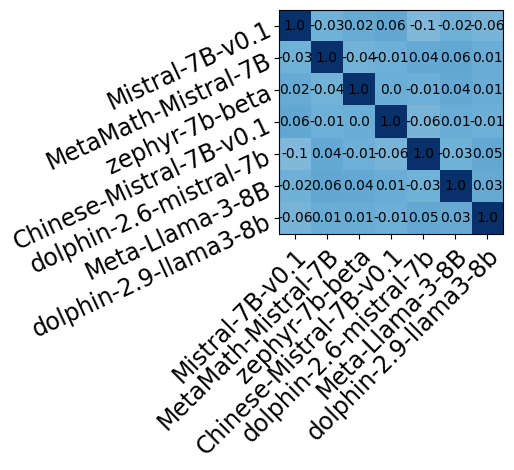

In [4]:

def compute_similarity(input1, input2):
    return (input1 @ input2.T) / (torch.norm(input1,dim=1).unsqueeze(1) * torch.norm(input2,dim=1).unsqueeze(0))
with torch.no_grad():
    embedding_weight = router_model.embeddings.weight.clone()
    # exchange embedding weight with chinese and h4
    embedding_weight[[2, 3]] = embedding_weight[[3,2]]
    cos_similarity = compute_similarity(embedding_weight, embedding_weight)

    cos_similarity = cos_similarity.cpu().numpy()
    cos_similarity = np.around(cos_similarity,2) 

print(cos_similarity)

models_name = ['Mistral-7B-v0.1','MetaMath-Mistral-7B',"zephyr-7b-beta",'Chinese-Mistral-7B-v0.1', "dolphin-2.6-mistral-7b", "Meta-Llama-3-8B", "dolphin-2.9-llama3-8b"]
plot_matrix(models_name, models_name, cos_similarity, "LLM & LLM embedding similarity", save_path="/data/home/chensh/projects/LLM_router/figures/LLM_LLM_embedding_similarity.pdf")

In [5]:
similar_matrixs = get_similar_matrixs(router_model, dataset_paths, data_types, tokenizer, 64, "cuda")

print(similar_matrixs)

similar_matrixs = torch.stack(similar_matrixs) 
similar_matrixs = similar_matrixs.cpu().numpy().T

similar_matrixs[[2, 3]] = similar_matrixs[[3, 2]]

similar_matrixs = np.around(similar_matrixs,2) 



[tensor([ 0.0830, -0.1211, -0.1543, -0.1492,  0.1194,  0.0261,  0.1442],
       device='cuda:0'), tensor([-0.2967,  0.6826, -0.0703, -0.3420, -0.1200, -0.1041,  0.3235],
       device='cuda:0'), tensor([-0.1654, -0.1315,  0.0854, -0.0530,  0.0649,  0.3286, -0.1015],
       device='cuda:0'), tensor([-0.2040,  0.0096, -0.2495,  0.4635,  0.2760, -0.0972, -0.1665],
       device='cuda:0'), tensor([ 0.0245, -0.2284, -0.2605, -0.1169,  0.2195, -0.0528,  0.3652],
       device='cuda:0'), tensor([-0.3385,  0.4532, -0.1602, -0.3066,  0.0423, -0.0287,  0.3837],
       device='cuda:0'), tensor([-0.1277, -0.0171, -0.2073, -0.2358,  0.1756,  0.0790,  0.2886],
       device='cuda:0'), tensor([-0.1894, -0.1332,  0.0749, -0.0527,  0.0777,  0.3349, -0.0825],
       device='cuda:0')]


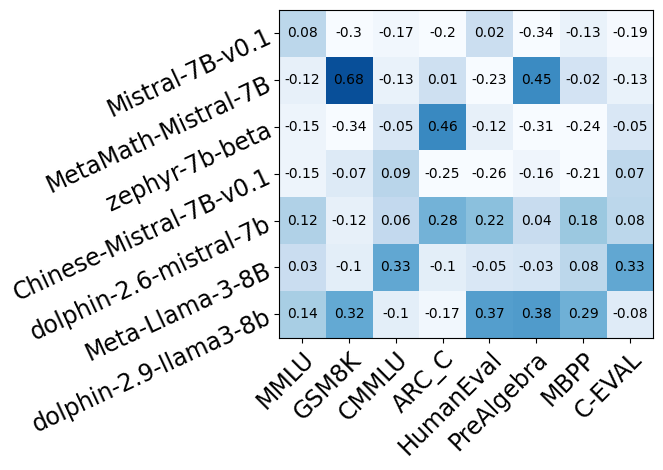

In [6]:
def plot_matrix(x_name, y_name, matrix, title, save_path):
    fig, ax = plt.subplots()
    im = ax.imshow(matrix, cmap='Blues', vmin=-0.2, vmax=0.8)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(x_name)), labels=x_name, fontsize=17)
    ax.set_yticks(np.arange(len(y_name)), labels=y_name,  fontsize=17)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=25, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(x_name)):
        for j in range(len(y_name)):
            # if matrix[j, i] < 0.4:
            # text = ax.text(i, j, matrix[j, i],
            #             ha="center", va="center", color="w")
            # else:
            text = ax.text(i, j, matrix[j, i],
                        ha="center", va="center", color="black")
            
    # ax.set_title(title)
    fig.tight_layout()
    plt.savefig(save_path, dpi=800, bbox_inches = 'tight')



models_name = ['Mistral-7B-v0.1','MetaMath-Mistral-7B',"zephyr-7b-beta",'Chinese-Mistral-7B-v0.1',"dolphin-2.6-mistral-7b", "Meta-Llama-3-8B", "dolphin-2.9-llama3-8b"]
dataset_name = ["MMLU", "GSM8K","CMMLU","ARC_C","HumanEval","PreAlgebra", "MBPP", "C-EVAL"]
plot_matrix(dataset_name, models_name, similar_matrixs, "LLM & sample embedding similarity", save_path="/data/home/chensh/projects/LLM_router/figures/LLM_sample_embedding_similarity.pdf")

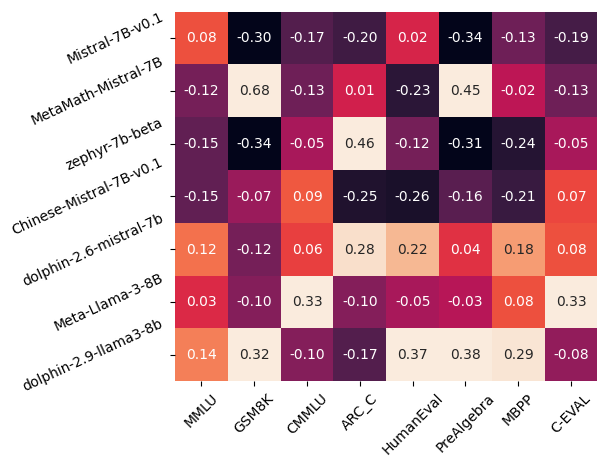

In [32]:
import seaborn as sns
models_name = ['Mistral-7B-v0.1','MetaMath-Mistral-7B',"zephyr-7b-beta",'Chinese-Mistral-7B-v0.1',"dolphin-2.6-mistral-7b", "Meta-Llama-3-8B", "dolphin-2.9-llama3-8b"]
dataset_name = ["MMLU", "GSM8K","CMMLU","ARC_C","HumanEval","PreAlgebra", "MBPP", "C-EVAL"]
sns.heatmap(similar_matrixs, square=True, annot=True, fmt='0.2f', xticklabels=dataset_name, yticklabels=models_name, cbar=False, vmin=-0.3, vmax=0.3)
plt.xticks(rotation=45)
plt.yticks(rotation=25)
plt.savefig("/data/home/chensh/projects/LLM_router/figures/LLM_sample_embedding_similarity_v2.pdf", dpi=800, bbox_inches = 'tight')